In [ ]:
import os
import pandas as pd
from pydantic import BaseModel
from openai import OpenAI
import base64
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import numpy as np


In [5]:
df = pd.read_csv('data.csv')

In [6]:
df_sample = df.sample(100)

In [7]:

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [8]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
system_message = """
You are a high-fidelity evaluator for textual prompts and their generated images. Given a text prompt and its corresponding generated image, evaluate two dimensions:

- Text-Image Alignment (float number in range 0-10)
- Perceptual Quality (float number in range 0-10)

Return only the scores.
"""
# Define Pydantic models for the structured evaluation output

class EvaluationOutput(BaseModel):
    text_image_alignment_score: float
    perceptual_quality_score: float

# Define your text prompt and encode the image to base64


In [9]:
def get_scores(image_path, prompt):

    base64_image = encode_image(image_path)

    # Create the user message including both text and image information
    user_message = [
        {"type": "text", "text": f"Text prompt: {prompt}"},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
    ]



    # Call the API using the beta parse method for structured output
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_message}
        ],
        response_format=EvaluationOutput,
        max_tokens=30
    )

    # Extract the parsed evaluation output
    evaluation = completion.choices[0].message.parsed
    return evaluation.text_image_alignment_score, evaluation.perceptual_quality_score

In [10]:
root_dir = './datasets'
al_scores = []
perc_scores = []
for row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    idx = row[0]
    sample = row[1]
    al, perc = get_scores(image_path=os.path.join(root_dir, sample['name']), prompt=sample['prompt'])
    al_scores.append(al)
    perc_scores.append(perc)

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
df_sample["gpt_al"] = al_scores
df_sample["gpt_perc"] = perc_scores

In [ ]:
df_sample

,name,prompt,adj1,adj2,style,mos_quality,std_quality,mos_align,std_align,gpt_al,gpt_perc
2814,xl2.2_normal_132.jpg,"a girl with rainbow in white shirt , top view",top view,NaN,NaN,3.628002,0.638229,3.114137,0.672713,8.0,7.5
2000,sd1.5_lowcorr_218.jpg,a masonic illuminati waiting room with a couch...,soft lighting,NaN,abstract style,3.434559,0.507418,3.137696,0.293138,7.5,8.0
1205,midjourney_normal_019.jpg,big boss eating dinner,NaN,NaN,NaN,3.657122,0.549470,3.377805,0.816266,9.0,8.5
812,glide_normal_222.jpg,interior of cosmic highway created by the gods...,cold color,top view,NaN,1.461648,0.595325,1.389857,1.102856,4.0,5.0
424,DALLE2_normal_130.jpg,"photography of a happy blonde girl , warm color",warm color,NaN,NaN,2.472263,0.539185,3.125989,0.972795,9.0,8.5
...,...,...,...,...,...,...,...,...,...,...,...
409,DALLE2_normal_115.jpg,"ocean of canvas that catches fire, anime style",NaN,NaN,anime style,1.696020,0.788313,2.094906,0.904053,4.0,6.0
767,glide_normal_177.jpg,"a huge wooden carving sculpture of a fox, hype...",hyper detail,NaN,NaN,0.128896,0.376052,0.341603,0.402970,1.0,2.0
2268,sd1.5_lowstep_186.jpg,"a portrait of girl alchemist in blue dress, bl...",blurred detail,NaN,sci-fi style,2.938008,0.527846,2.865255,0.806532,8.5,9.0
964,midjourney_lowstep_075.jpg,"concept art of octopus attack, anime style",NaN,NaN,anime style,2.429569,0.426363,3.357572,0.620503,7.0,8.0


In [22]:
df_sample.corr(method='spearman', numeric_only=True)

,mos_quality,std_quality,mos_align,std_align,gpt_al,gpt_perc
mos_quality,1.000000,0.079988,0.763137,-0.162052,0.600066,0.710590
std_quality,0.079988,1.000000,0.088035,0.255230,0.081925,0.039007
mos_align,0.763137,0.088035,1.000000,-0.248708,0.713263,0.725246
std_align,-0.162052,0.255230,-0.248708,1.000000,-0.176593,-0.196932
gpt_al,0.600066,0.081925,0.713263,-0.176593,1.000000,0.884695
gpt_perc,0.710590,0.039007,0.725246,-0.196932,0.884695,1.000000


In [25]:
df_sample.to_csv('res.csv')

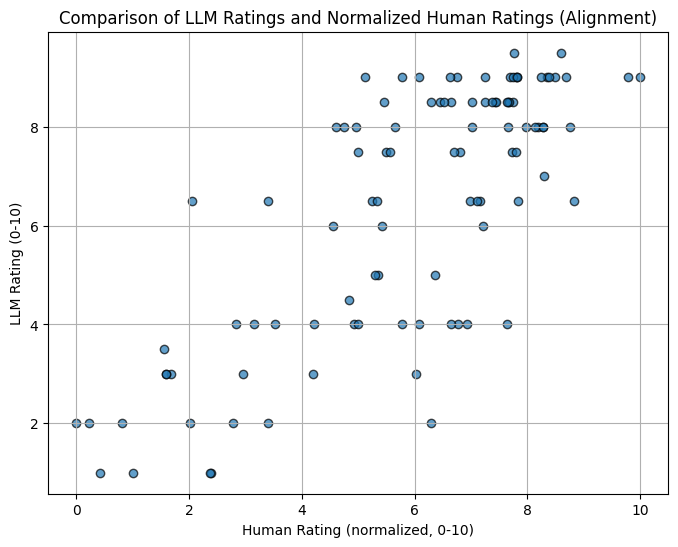

Pearson correlation coefficient: 0.771 (p-value: 0.000)
Spearman correlation coefficient: 0.713 (p-value: 0.000)
Coefficient of determination (R²): 0.595


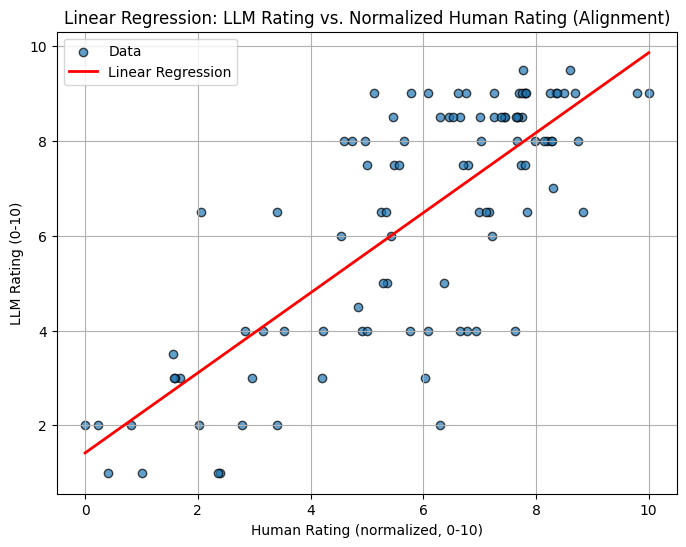

In [ ]:


# Load data from CSV.
# The dataset should contain the columns "mos_align" (human rating) and "gpt_al" (LLM rating, range 0-10)
df = df_sample.copy()

# Determine the minimum and maximum values for the human ratings
human_min = df["mos_align"].min()
human_max = df["mos_align"].max()

# Normalize human ratings to the 0–10 range using:
# normalized_rating = (rating - min) / (max - min) * 10
df["human_norm"] = (df["mos_align"] - human_min) / (human_max - human_min) * 10

# Visualization: Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df["human_norm"], df["gpt_al"], alpha=0.7, edgecolors='k')
plt.xlabel("Human Rating (normalized, 0-10)")
plt.ylabel("LLM Rating (0-10)")
plt.title("Comparison of LLM Ratings and Normalized Human Ratings (Alignment)")
plt.grid(True)
plt.show()

# Calculate the Pearson correlation coefficient
pearson_corr, pearson_p = pearsonr(df["human_norm"], df["gpt_al"])
print(f"Pearson correlation coefficient: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")

# Calculate the Spearman correlation coefficient
spearman_corr, spearman_p = spearmanr(df["human_norm"], df["gpt_al"])
print(f"Spearman correlation coefficient: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

# Build a linear regression model
X = df["human_norm"].values.reshape(-1, 1)
y = df["gpt_al"].values
model = LinearRegression()
model.fit(X, y)
r2 = model.score(X, y)
print(f"Coefficient of determination (R²): {r2:.3f}")

# Visualization of the regression model
plt.figure(figsize=(8, 6))
plt.scatter(df["human_norm"], df["gpt_al"], alpha=0.7, edgecolors='k', label="Data")
x_line = np.linspace(df["human_norm"].min(), df["human_norm"].max(), 100)
y_line = model.predict(x_line.reshape(-1, 1))
plt.plot(x_line, y_line, color='red', linewidth=2, label="Linear Regression")
plt.xlabel("Human Rating (normalized, 0-10)")
plt.ylabel("LLM Rating (0-10)")
plt.title("Linear Regression: LLM Rating vs. Normalized Human Rating (Alignment)")
plt.legend()
plt.grid(True)
plt.show()


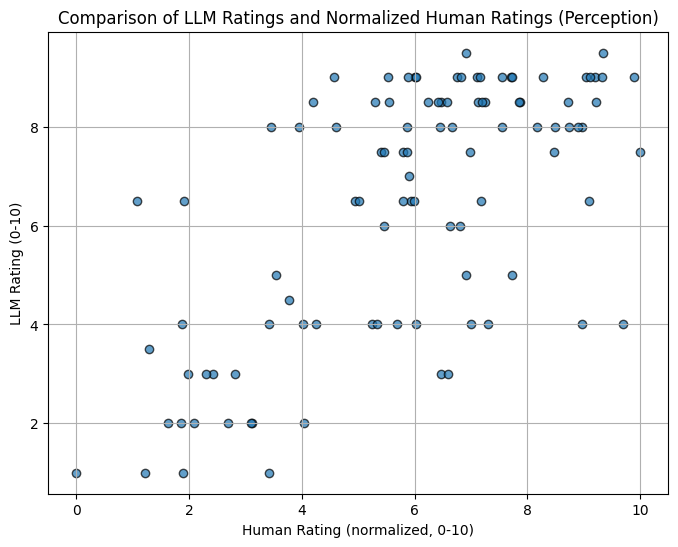

Pearson correlation coefficient: 0.778 (p-value: 0.000)
Spearman correlation coefficient: 0.711 (p-value: 0.000)
Coefficient of determination (R²): 0.605


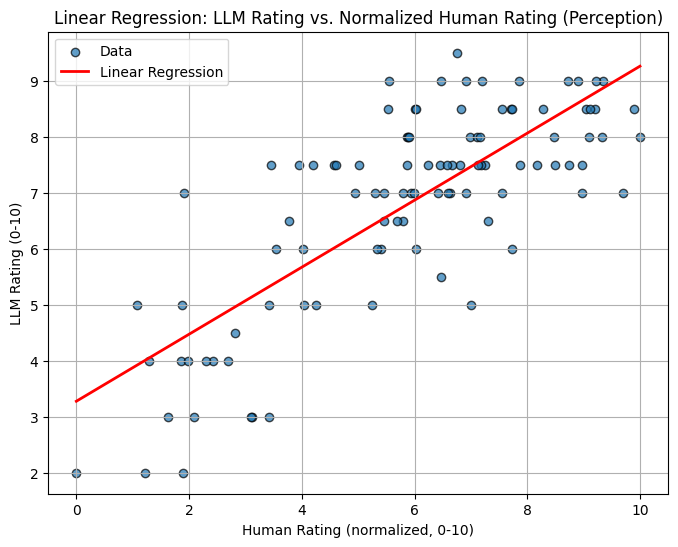

In [ ]:


# Load data from CSV.
# The dataset should contain the columns "mos_align" (human rating) and "gpt_al" (LLM rating, range 0-10)
df = df_sample.copy()

# Determine the minimum and maximum values for the human ratings
human_min = df["mos_quality"].min()
human_max = df["mos_quality"].max()

# Normalize human ratings to the 0–10 range using:
# normalized_rating = (rating - min) / (max - min) * 10
df["human_norm"] = (df["mos_quality"] - human_min) / (human_max - human_min) * 10

# Visualization: Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df["human_norm"], df["gpt_al"], alpha=0.7, edgecolors='k')
plt.xlabel("Human Rating (normalized, 0-10)")
plt.ylabel("LLM Rating (0-10)")
plt.title("Comparison of LLM Ratings and Normalized Human Ratings (Perception)")
plt.grid(True)
plt.show()

# Calculate the Pearson correlation coefficient
pearson_corr, pearson_p = pearsonr(df["human_norm"], df["gpt_perc"])
print(f"Pearson correlation coefficient: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")

# Calculate the Spearman correlation coefficient
spearman_corr, spearman_p = spearmanr(df["human_norm"], df["gpt_perc"])
print(f"Spearman correlation coefficient: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

# Build a linear regression model
X = df["human_norm"].values.reshape(-1, 1)
y = df["gpt_perc"].values
model = LinearRegression()
model.fit(X, y)
r2 = model.score(X, y)
print(f"Coefficient of determination (R²): {r2:.3f}")

# Visualization of the regression model
plt.figure(figsize=(8, 6))
plt.scatter(df["human_norm"], df["gpt_perc"], alpha=0.7, edgecolors='k', label="Data")
x_line = np.linspace(df["human_norm"].min(), df["human_norm"].max(), 100)
y_line = model.predict(x_line.reshape(-1, 1))
plt.plot(x_line, y_line, color='red', linewidth=2, label="Linear Regression")
plt.xlabel("Human Rating (normalized, 0-10)")
plt.ylabel("LLM Rating (0-10)")
plt.title("Linear Regression: LLM Rating vs. Normalized Human Rating (Perception)")
plt.legend()
plt.grid(True)
plt.show()
